In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from src.cfd import CFD, find_optimal_cfd_threshold
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_history, plot_difference_hist, compare_results

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PLANE = 2
CHANNEL = 11

PRINT_PCOV = False

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

all_X, all_y = dataset[(PLANE, CHANNEL)][0], dataset[(PLANE, CHANNEL)][1]
all_X.shape, all_y.shape

((28015, 24), (28015,))

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Preprocess

In [5]:
N_BASELINE = 8

In [6]:
# turns out the networks do better without the normalisation, CFD has to use normalised waveforms anyway
# all_X -= np.mean(all_X[:, :N_BASELINE], axis=1)[:, None]
# all_X /= all_X.max(axis=1)[:, None]

X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21011, 24), (7004, 24), (21011,), (7004,))

# Utils

In [7]:
def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, lr=0.001, train=False,
                n_epochs=1000, verbose=2, batch_size=2048, lr_patience=None, es_patience=None, loss_weights=None):
    return _base_train_model(model, name, 'basic_tests', X_train, y_train, X_val, y_val, lr, train, n_epochs, verbose,
                             batch_size, lr_patience, es_patience, loss_weights, root=PWD + '/data')

# CFD

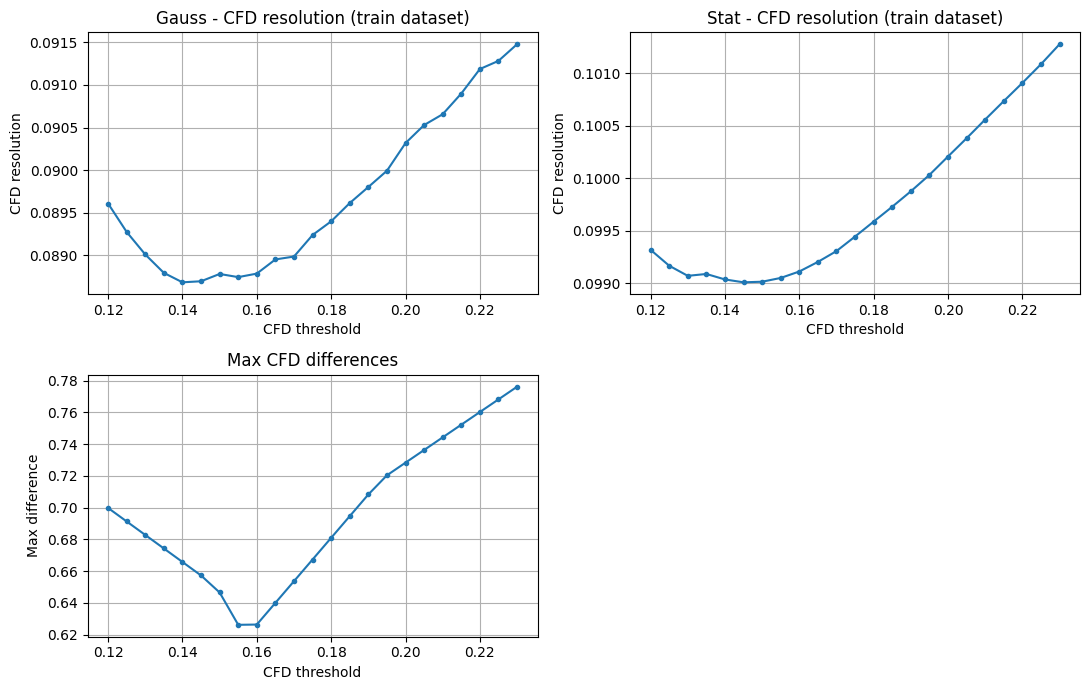

Optimal CFD threshold: 0.145


In [8]:
thresholds = np.arange(0.12, 0.23, 0.005)
optimal_cfd_threshold = find_optimal_cfd_threshold(thresholds, N_BASELINE, X_train, y_train, x_time, n_jobs=16)

In [9]:
cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_threshold)

y_pred = cfd.predict(x_time, X_test)

In [10]:
np.std(y_pred - y_test)

0.09986252482443399

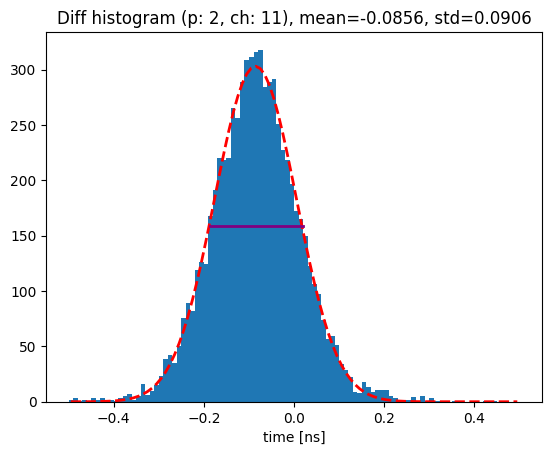

In [11]:
std_cfd_hist, pcov, fwhm_cfd = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_cfd_stat = np.std(y_pred - y_test)

# MLP 1

In [12]:
mlp_1_name = model_name = 'MLP 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.1, train=False, n_epochs=3000, lr_patience=50, es_patience=200,
                      loss_weights=1000)

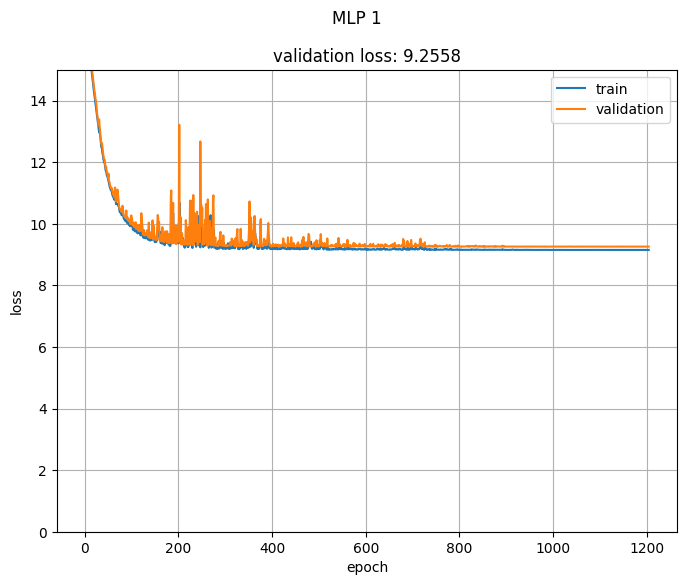

In [13]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 1s 516us/step


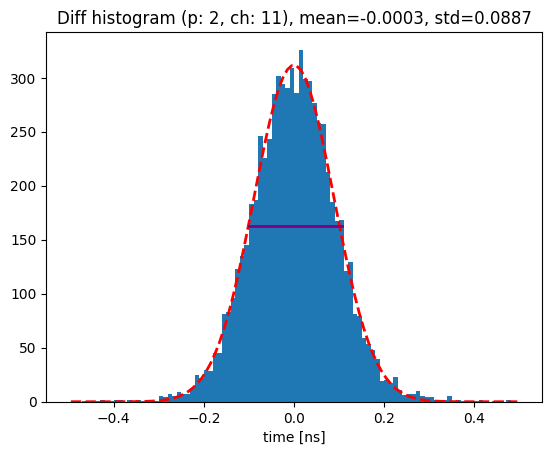

In [14]:
y_pred = model.predict(X_test)[:, 0]
std_1_hist, pcov, fwhm_1 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_1_stat = np.std(y_pred - y_test)

# MLP 2

In [15]:
mlp_2_name = model_name = 'MLP 2'
model = keras.Sequential([
    layers.Input(24),

    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400,
                      loss_weights=1000)

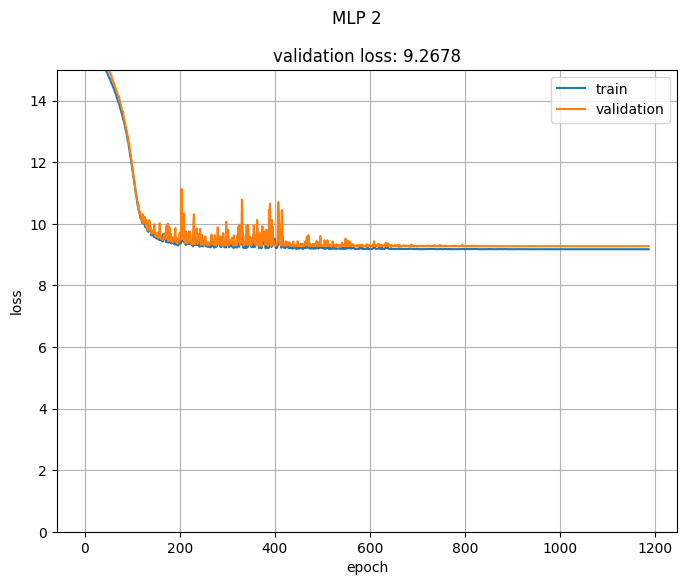

In [16]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 681us/step


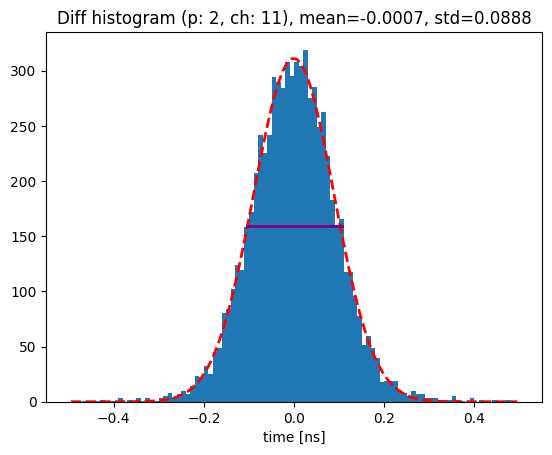

In [17]:
y_pred = model.predict(X_test)[:, 0]
std_2_hist, pcov, fwhm_2 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_2_stat = np.std(y_pred - y_test)

# Convolutional network 1

In [18]:
cnn_1_name = model_name = 'CNN 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.Conv1D(16, 3, padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=200,
                      loss_weights=1000)

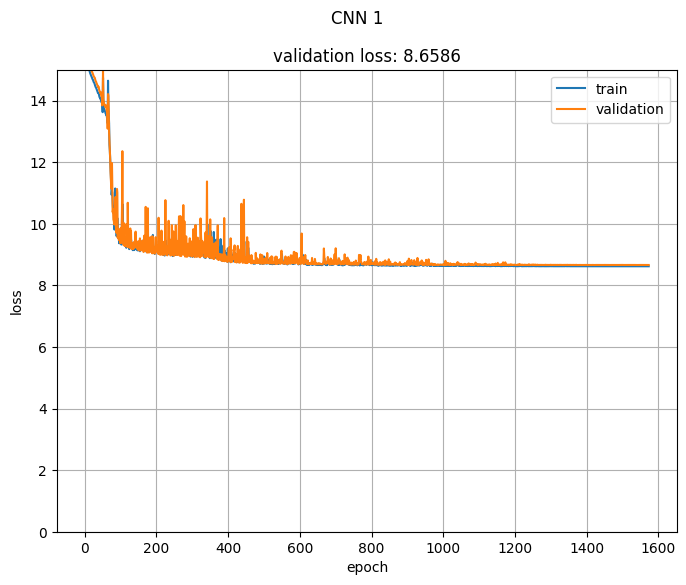

In [19]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 1s 622us/step


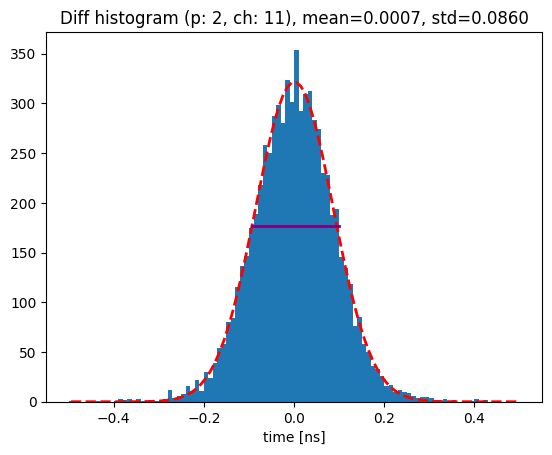

In [20]:
y_pred = model.predict(X_test)[:, 0]
std_3_hist, pcov, fwhm_3 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_3_stat = np.std(y_pred - y_test)

# Convolutional network 2

In [21]:
cnn_2_name = model_name = 'CNN 2'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.Conv1D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),

    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400,
                      loss_weights=1000)

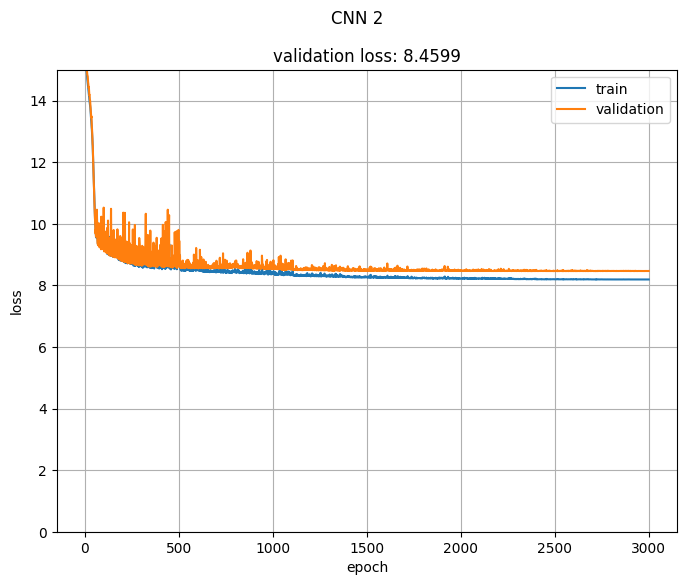

In [22]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 0s 829us/step


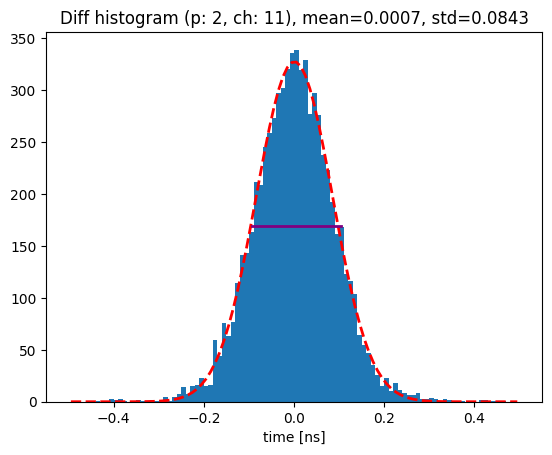

In [23]:
y_pred = model.predict(X_test)[:, 0]
std_4_hist, pcov, fwhm_4 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_4_stat = np.std(y_pred - y_test)

# UNet

In [24]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


get_gauss_stats(np.arange(24), gaussian_kernel(np.array(1.6)))[0]

1.0

In [25]:
Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

In [26]:
unet_name = model_name = 'UNet'


def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x


def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x


###################################

inputs = layers.Input(24)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 64)
skip2, x = conv_block(x, 128)
skip3, x = conv_block(x, 256)
x, _ = conv_block(x, 512)

x = deconv_block(x, skip3, 256)
x = deconv_block(x, skip2, 128)
x = deconv_block(x, skip1, 64)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, model_name, y_train=Y_heatmap_train, y_val=Y_heatmap_test, lr=0.0005, train=False,
                      n_epochs=3000, lr_patience=50, es_patience=300, loss_weights=10000)

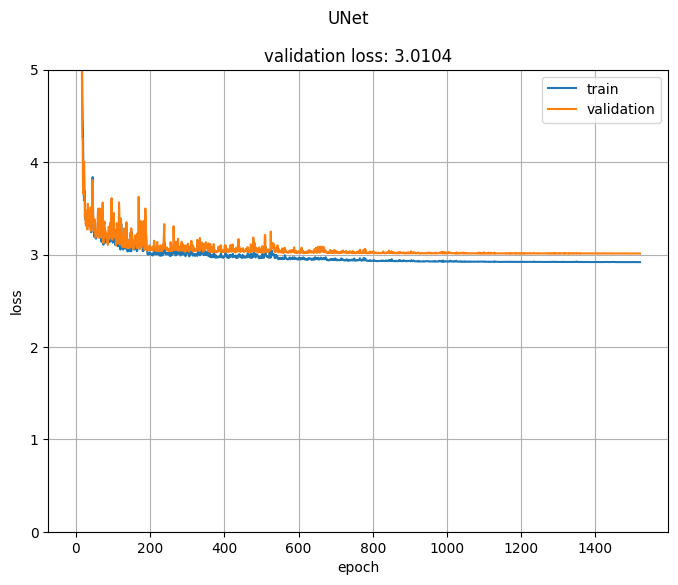

In [27]:
plot_history(history, model_name, ymax=5)

219/219 [==============================] - 1s 3ms/step


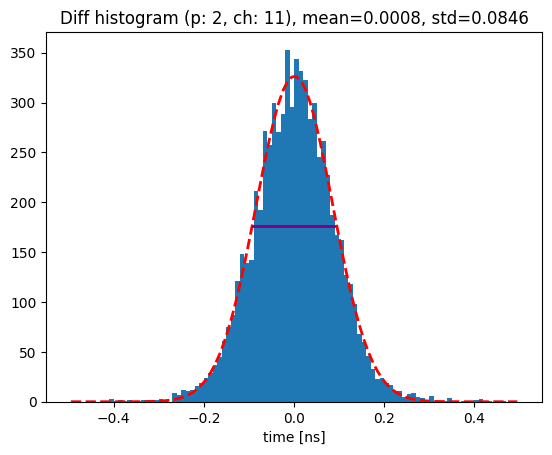

In [28]:
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

std_5_hist, pcov, fwhm_5 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_5_stat = np.std(y_pred - y_test)

# RNN

In [29]:
rnn_name = model_name = 'RNN'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),

    layers.LSTM(512),

    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.005, train=False, n_epochs=3000, lr_patience=50, es_patience=200,
                      loss_weights=1000)

In [30]:
# model.summary()

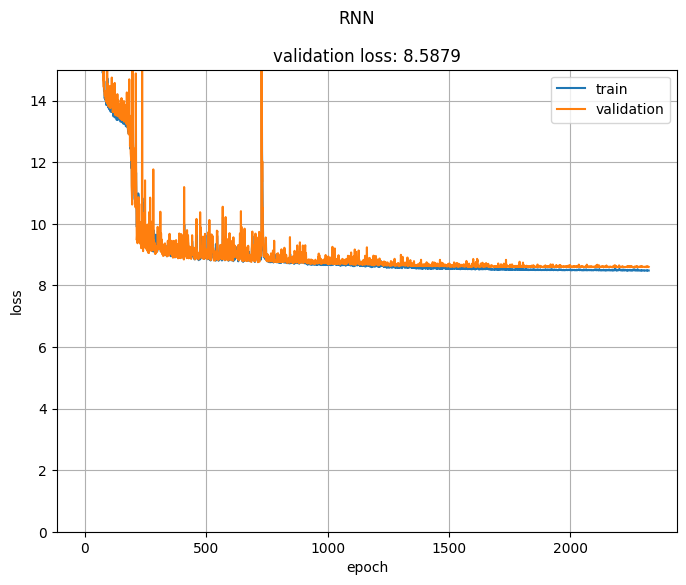

In [31]:
plot_history(history, model_name, ymax=15)

219/219 [==============================] - 1s 2ms/step


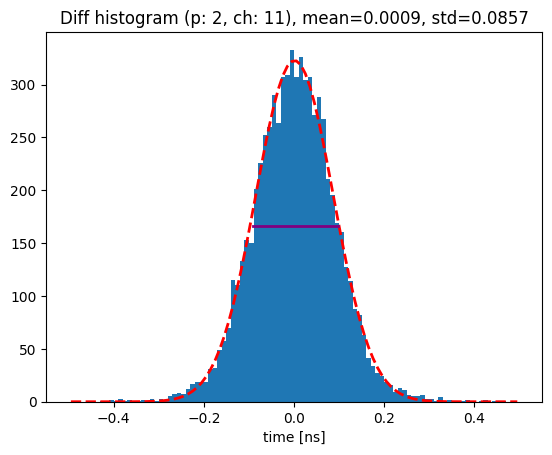

In [32]:
y_pred = model.predict(X_test)[:, 0]
std_6_hist, pcov, fwhm_6 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_6_stat = np.std(y_pred - y_test)

# Compare standard deviations

### Difference histogram – Gauss

In [33]:
compare_results([std_1_hist, std_2_hist, std_3_hist, std_4_hist, std_5_hist, std_6_hist],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], std_cfd_hist)

       CFD: 90.59 ps
     CNN 2: 84.31 ps (improvement: 6.93 %)
      UNet: 84.58 ps (improvement: 6.63 %)
       RNN: 85.75 ps (improvement: 5.34 %)
     CNN 1: 85.96 ps (improvement: 5.11 %)
     MLP 1: 88.69 ps (improvement: 2.10 %)
     MLP 2: 88.81 ps (improvement: 1.96 %)


### Stat

In [34]:
compare_results([std_1_stat, std_2_stat, std_3_stat, std_4_stat, std_5_stat, std_6_stat],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], std_cfd_stat)

       CFD: 99.86 ps
     CNN 2: 91.98 ps (improvement: 7.90 %)
      UNet: 92.00 ps (improvement: 7.87 %)
       RNN: 92.67 ps (improvement: 7.20 %)
     CNN 1: 93.05 ps (improvement: 6.82 %)
     MLP 1: 96.21 ps (improvement: 3.66 %)
     MLP 2: 96.27 ps (improvement: 3.60 %)


### Full width at half maximum (FWHM)

In [35]:
compare_results([fwhm_1, fwhm_2, fwhm_3, fwhm_4, fwhm_5, fwhm_6],
                [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name], fwhm_cfd)

       CFD: 207.42 ps
      UNet: 179.32 ps (improvement: 13.55 %)
       RNN: 188.42 ps (improvement: 9.16 %)
     CNN 1: 193.22 ps (improvement: 6.85 %)
     CNN 2: 197.52 ps (improvement: 4.77 %)
     MLP 1: 206.92 ps (improvement: 0.24 %)
     MLP 2: 211.22 ps (improvement: -1.83 %)
